## Compare SOC dependency on SEI model

In [49]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl; 
fs=17
font = {'family' : 'DejaVu Sans',  'size'   : fs}
mpl.rc('font', **font)

In [50]:
# task: post-processing - adjust to make the cell degrade to a reasonable value
variables = [
    "Time [h]",
    "Discharge capacity [A.h]",
    "Positive electrode capacity [A.h]",
    "Negative electrode capacity [A.h]",
    "Loss of capacity to negative SEI [A.h]",
    "Total lithium capacity in particles [A.h]",

    "Positive electrode stoichiometry",
    "Negative electrode stoichiometry",
]
Short_ylabel ={
    "Discharge capacity [A.h]": "Cap / A.h" ,
    "Positive electrode capacity [A.h]": "Cap_Pe / A.h",
    "Negative electrode capacity [A.h]": "Cap_Ne / A.h",
    "Loss of capacity to negative SEI [A.h]": "LLI to SEI / A.h",
    "Total lithium capacity in particles [A.h]": "Li in Particle / A.h" ,
    "Positive electrode stoichiometry Start": "PE Sto Start" ,
    "Negative electrode stoichiometry Start": "NE Sto Start" ,
    "Positive electrode stoichiometry End": "PE Sto End" ,
    "Negative electrode stoichiometry End": "NE Sto End" ,
}

def Run_Age_w_RPT(model, param, variables, age_T, total_cycles, num_one_age_set):
    # age_T is the ageing temperature in degC
    
    
    num_loop = total_cycles / num_one_age_set
    age_experiment = pybamm.Experiment(
        [
            (        
                "Rest for 432 hours (24 hours period)", # 342 for 9.5 months
                # "Rest for 1 hours",
            )
        ] * num_one_age_set,   
    )
    rpt_experiment = pybamm.Experiment(
        [
            (        
                "Charge at 0.3C until 4.2 V",
                "Hold at 4.2 V until C/50",
                "Rest for 30 minutes",
                "Discharge at 0.3C until 2.8 V",
                "Rest for 30 minutes",
                "Charge at 0.3C until 4.2 V",
                "Hold at 4.2 V until C/50",
            )
        ] * 1,   
    )
    param["Initial temperature [K]"] = 273.15 + 25
    param["Ambient temperature [K]"] = 273.15 + 25
    def Get_customized_dict_from_sol_step(Sol_dict, step, variables, cyc_No):  
        Sol_dict["cyc no."].append(cyc_No)
        for var in variables:
            if var in ["Discharge capacity [A.h]"]:
                Q_dis_cyc = step["Discharge capacity [A.h]"].entries
                Q_dis = abs(Q_dis_cyc[-1] - Q_dis_cyc[0])
                Sol_dict[var].append(Q_dis)
            elif var in ["Positive electrode stoichiometry","Negative electrode stoichiometry"]:
                Sol_dict[var + " Start"].append(
                    step[var].entries[0])
                Sol_dict[var + " End"].append(
                    step[var].entries[-1])
            else:
                Sol_dict[var].append(step[var].entries[0] )
        return Sol_dict
    # run the process break in cycle
    sim = pybamm.Simulation(
        model, experiment=rpt_experiment, 
        parameter_values=param,
    )
    sol_rpt = sim.solve()
    
    Sol_dict = {}
    Sol_dict["cyc no."] = []
    for var in variables:
        if var in ["Positive electrode stoichiometry","Negative electrode stoichiometry"]:
            Sol_dict[var + " Start"] = []
            Sol_dict[var + " End"] = []
        else:
            Sol_dict[var] = []
    # post-process for break in / 1st RPT:
    Sol_dict = Get_customized_dict_from_sol_step(
        Sol_dict, sol_rpt.cycles[0].steps[3], variables, cyc_No=0)
    # now repeat:
    for i in range(int(num_loop)):
        # run age:
        param["Initial temperature [K]"] = 273.15 + age_T
        param["Ambient temperature [K]"] = 273.15 + age_T
        sim = pybamm.Simulation(
            model, experiment=age_experiment, 
            parameter_values=param,)
        sol_age = sim.solve(
            starting_solution=sol_rpt, save_at_cycles = num_one_age_set)
        # run rpt:
        param["Initial temperature [K]"] = 273.15 + 25
        param["Ambient temperature [K]"] = 273.15 + 25
        sim = pybamm.Simulation(
            model, experiment=rpt_experiment, 
            parameter_values=param,)
        sol_rpt = sim.solve(starting_solution=sol_age)
        Sol_dict = Get_customized_dict_from_sol_step(
            Sol_dict, sol_rpt.cycles[-1].steps[3], variables, 
            cyc_No=num_one_age_set*(i+1) )
    return Sol_dict


In [51]:
model = pybamm.lithium_ion.SPM({"SEI": "solvent-diffusion limited",})
for var, equation in model.initial_conditions.items():
    print(var)

Discharge capacity [A.h]
Throughput capacity [A.h]
X-averaged negative particle concentration [mol.m-3]
X-averaged positive particle concentration [mol.m-3]
X-averaged negative inner SEI thickness [m]
X-averaged negative outer SEI thickness [m]


In [52]:
param = pybamm.ParameterValues("Chen2020") 
options = [
    "solvent-diffusion limited", 
    "reaction limited",
    "electron-migration limited",
    "interstitial-diffusion limited",
]
keys = [
    "Outer SEI solvent diffusivity [m2.s-1]",
    "SEI reaction exchange current density [A.m-2]",
    "Inner SEI electron conductivity [S.m-1]",
    "Inner SEI lithium interstitial diffusivity [m2.s-1]",
]
values = [
    3e-20,
    1.15e-7,  # "reaction limited", 9.5e-8 is too small, 1.5e-7 is too big
    1e-9,
    2e-16
]

param["SEI growth activation energy [J.mol-1]"] =  5e4
total_cycles, num_one_age_set = 20, 1
age_T = 25
Sol_Dict_List = []
for i in range(4):
    model = pybamm.lithium_ion.SPM({"SEI": options[i]})
    param[keys[i]] = values[i]

    Sol_Dict_List.append(Run_Age_w_RPT(
        model, param, variables, age_T=age_T, 
        total_cycles=total_cycles, 
        num_one_age_set=num_one_age_set))


In [53]:
import os
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'../..'))
Save_fig_path = str_path_0 + "/examples/Reproduce_Paper"

In [54]:
Save_fig_path

'/home/ruihe_li/EnvPB_Linux/PyBaMM/examples/Reproduce_Paper'

In [55]:
cap_list = Sol_Dict_List[0]["Discharge capacity [A.h]"]
soh_list = cap_list / cap_list[0]
# soh_list

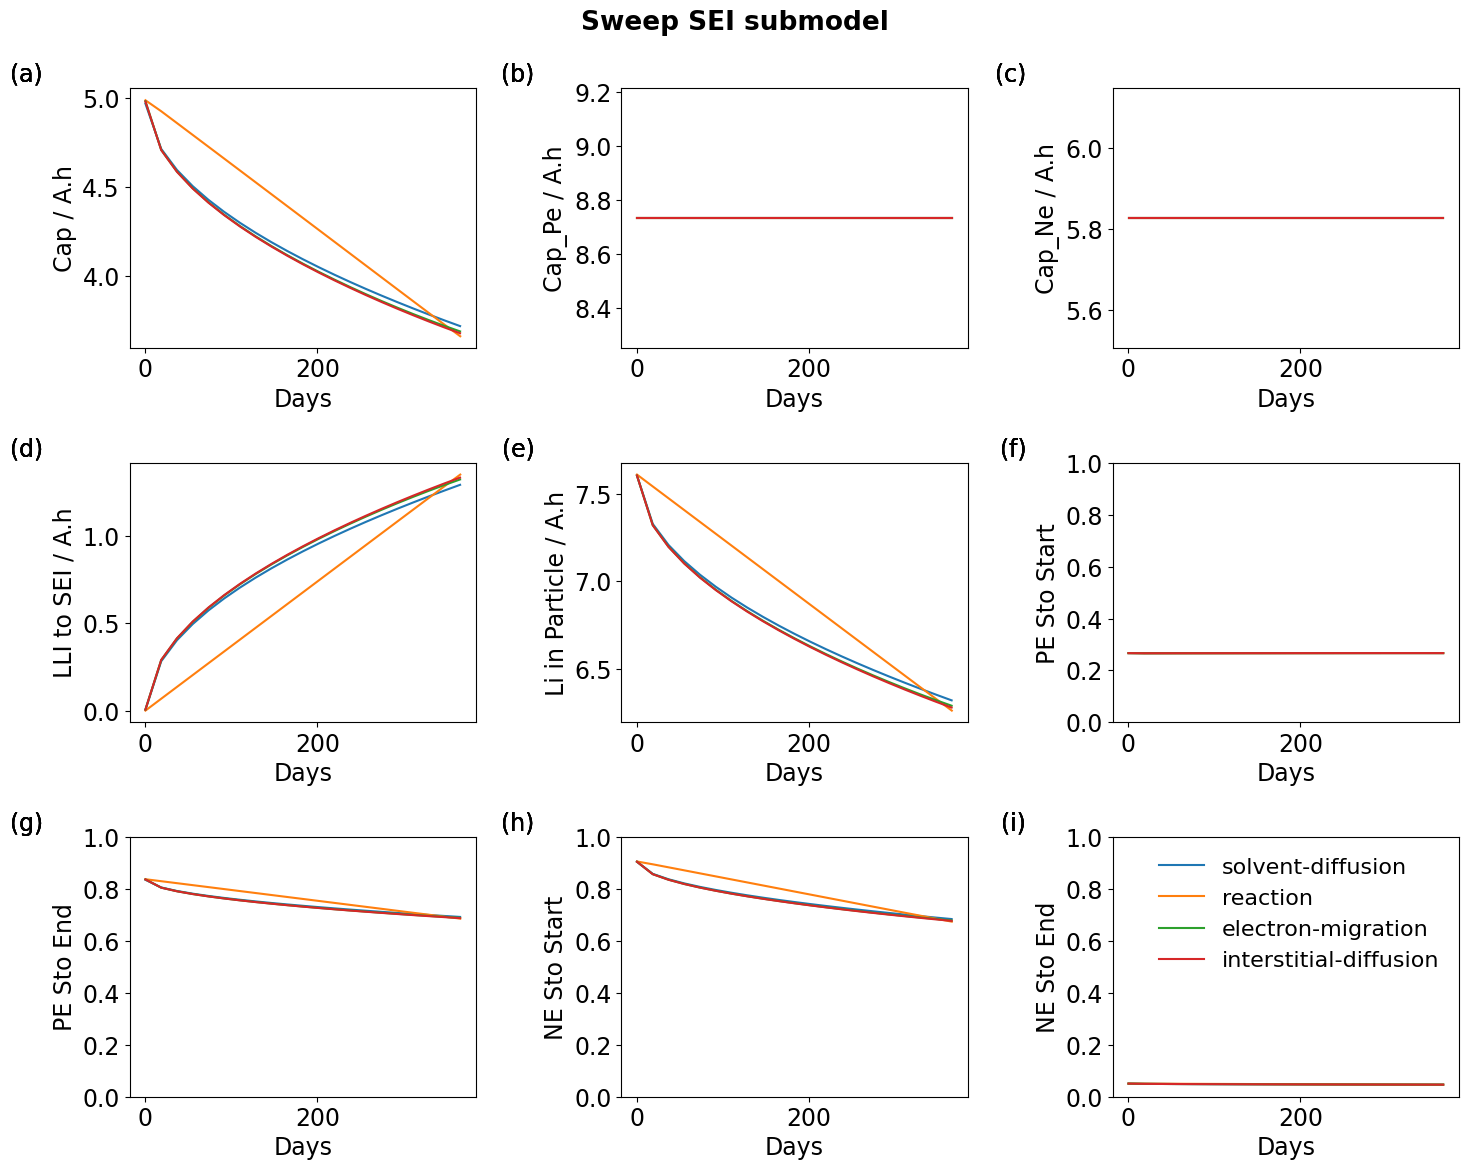

In [57]:
def Plot_Summary(Sol_dict, axs, label, subplot_labels):
    variables = Sol_dict.keys()
    i = 0
    for var in variables:
        if var in ["cyc no.", "Time [h]"]:
            pass
        else:
            axs[i].plot(
                np.array(Sol_dict["Time [h]"])/24,
                Sol_dict[var],"-", label = label)
            axs[i].set_ylabel(Short_ylabel[var])
            axs[i].set_xlabel("Days")
            axs[i].text(
                -0.25, 1.1, 
                subplot_labels[i], transform=axs[i].transAxes, 
                fontsize=fs,  # fontweight='bold', 
                va='top', ha='right')
            i += 1
    return axs

labels = [
    "solvent-diffusion", 
    "reaction",
    "electron-migration",
    "interstitial-diffusion",
]


subplot_labels = [
    "(a)", "(b)", "(c)", 
    "(d)", "(e)", "(f)", 
    "(g)", "(h)", "(i)", ]
fig, Axs = plt.subplots(3,3, figsize=(15,12),tight_layout=True)
axs = Axs.flatten()
for label, Sol_dict in zip(labels, Sol_Dict_List):
    axs = Plot_Summary(Sol_dict, axs, label=f"{label}", 
                       subplot_labels=subplot_labels)
fig.suptitle(
    "Sweep SEI submodel",  fontsize=fs+2, fontweight='bold', )
# axs[0].set_ylim([3.5,5])
for j in ([5,6,7,8]):
    axs[j].set_ylim([0,1])
#axs[0].set_ylim([3.6, 3.8])
axs[-1].legend(prop={'size':fs-1},
              loc='best',frameon=False)

fig.savefig(Save_fig_path + "/Sweep SEI submodel store at 100 SOC.svg")
